# Description

In [ ]:
# INFORMATION:

# This file lists the films in the MIAS database and provides     
# appropriate details as follows:

# 1st column: MIAS database reference number.

# 2nd column: Character of background tissue: 
#                 F - Fatty 
#                 G - Fatty-glandular
#                 D - Dense-glandular

# 3rd column: Class of abnormality present:
#                 CALC - Calcification
#                 CIRC - Well-defined/circumscribed masses
#                 SPIC - Spiculated masses
#                 MISC - Other, ill-defined masses
#                 ARCH - Architectural distortion
#                 ASYM - Asymmetry
#                 NORM - Normal

# 4th column: Severity of abnormality;
#                 B - Benign
#                 M - Malignant
                
# 5th,6th columns: x,y image-coordinates of centre of abnormality.

# 7th column: Approximate radius (in pixels) of a circle enclosing
# 	    the abnormality.
	    
# NOTES
# =====
# 1) The list is arranged in pairs of films, where each pair 
#    represents the left (even filename numbers) and right mammograms
#    (odd filename numbers) of a single patient.
   
# 2) The size of ALL the images is 1024 pixels x 1024 pixels. The images
#    have been centered in the matrix.  

# 3) When calcifications are present, centre locations and radii 
#    apply to clusters rather than individual calcifications.
#    Coordinate system origin is the bottom-left corner.

# 4) In some cases calcifications are widely distributed throughout
#    the image rather than concentrated at a single site. In these
#    cases centre locations and radii are inappropriate and have
#    been omitted.

# Info Load

In [1]:
path = '/content/drive/MyDrive/Colab Notebooks/breast_cancer/data/all-mias/'

import os

files = os.listdir(path)
files = [file for file in sorted(files) if file.endswith('pgm')]

import pandas as pd

# 짝수는 왼쪽 / 홀수는 오른쪽 (같은 환자)
# 아이디가 중복되는 pgm이 있음(8건) 좌표와 radius만 다르고 나머지는 같음 --> 여러 abnormal을 찾은것같음
# x = *NOTE y= 3*로 되어있는 abnormal이 3건있음
# 같은환자여도 오른쪽/왼쪽에 따라 Normal상태가 다름
# target: 4th column 
names = ['pgm', 
         'Character of background tissue',
         'Class of abnormality present',
         'Severity of abnormality',
         'x',
         'y',
         'radius']

info = pd.read_csv(path+'Info.txt', sep=' ', skiprows=101, names=names, skipfooter=1)


#label
info['label'] = info['Class of abnormality present'].apply(lambda x: 0 if x == "NORM" else 1)
print('label proportion')
print(info['label'].value_counts())

labels = info.drop_duplicates('pgm')['label'].values


### 이상치
# info.query(' y == "3*"')
# info.query(' x == "*NOTE"')

###중복
# dup = info[info.pgm.duplicated()].pgm.values
# info.query('pgm in @dup')

display(info.head(3))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


label proportion
0    207
1    123
Name: label, dtype: int64


,pgm,Character of background tissue,Class of abnormality present,Severity of abnormality,x,y,radius,label
0,mdb001,G,CIRC,B,535,425,197.0,1
1,mdb002,G,CIRC,B,522,280,69.0,1
2,mdb003,D,NORM,NaN,None,None,NaN,0


# Image Load / Augmentation

In [2]:
import cv2
import numpy as np
from tqdm.notebook import tqdm

def read_image_aug(name):
  
  file = name + '.pgm'
  img = cv2.imread(path + file)[:, :, 0] / 255
  img = cv2.resize(img, (224, 224))

  rows, cols = img.shape
  
  # augmentation
  aug = []
  no_angles = 360
  
  for angle in range(0, no_angles, 8):
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1) # 회전중심 , 회전각도, 확대
    img_rotated = cv2.warpAffine(img, M, (cols, rows)) #그림, 그림회전, (새세로, 새가로)
    aug.append(img_rotated)
  
  return np.array(aug)


# make X, y
X = []
y = []

unNormal = info.dropna(subset=['Severity of abnormality']).drop_duplicates('pgm')
print(unNormal['Severity of abnormality'].value_counts())

for name, label in tqdm(unNormal.iloc[:, [0, 3]].values):
  
  #image augmentation
  X.append(read_image_aug(name))

  #Benign #양성
  if label == 'B': 
    y.append(np.zeros((45, 1)))

  #Malignant #악성 #target
  else: 
    y.append(np.ones((45, 1)))

  
X = np.concatenate(X)[:, np.newaxis, :, :]
y = np.concatenate(y)

print(X.shape, y.shape)

B    64
M    51
Name: Severity of abnormality, dtype: int64



(5175, 1, 224, 224) (5175, 1)


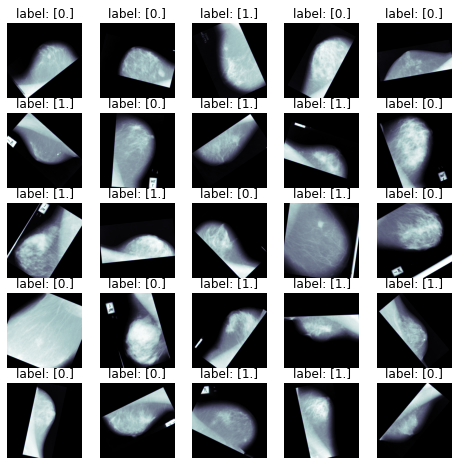

In [3]:
import matplotlib.pyplot as plt
n = 0
plt.figure(figsize=(8, 8))
for i in range(5):
  for j in range(5):
    n += 1
    plt.subplot(5, 5, n)
    plt.imshow(X[n*151,0], cmap=plt.cm.bone)
    plt.title(f'label: {y[n*151]}')
    plt.axis('off')

# Label Proportion / Baseline

Text(0.5, 1.0, 'Label Ratio')

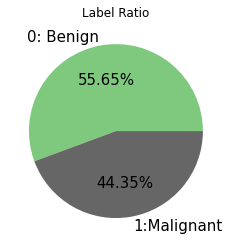

In [4]:
pd.Series(y.flatten()).value_counts().plot.pie(cmap=plt.cm.Accent, label='', labels=['0: Benign', '1:Malignant'], fontsize=15, autopct='%0.2f%%')
plt.title('Label Ratio', fontsize=12)

# make DataLoader / Split Data

In [16]:
import torch
import random

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(111)
torch.manual_seed(777)
if DEVICE == 'cuda':
    torch.cuda.manual_seed_all(777)

X_tensor = torch.Tensor(X)
y_tensor = torch.Tensor(y)

dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)

train_size = 3000 
val_size = 1100
test_size = 1075
BATCH_SIZE = 64

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size + val_size, test_size])
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

print('train_dataset: ', len(train_dataset)) 
print('val_dataset: ', len(val_dataset)) 
print('test_dataset: ', len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= BATCH_SIZE)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size= BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= BATCH_SIZE)


train_dataset:  3000
val_dataset:  1100
test_dataset:  1075


# model


In [32]:
import torch
import numpy as np
class Classifier(torch.nn.Module):

  def __init__(self):
    super(Classifier, self).__init__()
    
    self.conv_block1, self.shape = self.conv_block(224, 1, 8, 3, padding=1) 
    self.conv_block2, self.shape = self.conv_block(self.shape, 8, 16, 3, stride=2)
    self.conv_block3, self.shape = self.conv_block(self.shape, 16, 16, 3, padding=1)
    self.conv_block4, self.shape = self.conv_block(self.shape, 16, 32, 3, stride=2)
    self.conv_block5, self.shape = self.conv_block(self.shape, 32, 32, 3, padding=1)
    self.conv_block6, self.shape = self.conv_block(self.shape, 32, 64, 3, stride=2)
    self.conv_block7, self.shape = self.conv_block(self.shape, 64, 64, 3, padding=1)
    self.conv_block8, self.shape = self.conv_block(self.shape, 64, 128, 3, stride=2)


    print('last width: ', self.shape)
    self.fc_block1 = self.fc_block(128 * self.shape**2, 256)
    self.fc_block2 = self.fc_block(256, 128)
    self.fc_block3 = self.fc_block(128, 32)

    self.output = torch.nn.Linear(32, 1)

  def conv_block(self, shape, in_, out_, kernel, stride= 1, padding=0):
    block = torch.nn.Sequential(
        torch.nn.Conv2d(in_, out_, kernel, stride=stride, padding=padding, bias=False),
        torch.nn.BatchNorm2d(out_),
        torch.nn.ReLU()
    )

    shape = int(np.floor((shape - kernel + 2*padding) / stride) + 1 )

    return block, shape

  def fc_block(self, in_, out_):
    block = torch.nn.Sequential(
        torch.nn.Linear(in_, out_, bias=False),
        torch.nn.BatchNorm1d(out_),
        torch.nn.ReLU()
    )
    return block

  def forward(self, x):
    # (1, 224, 224)
    x = self.conv_block1(x) # (8, 224, 224)
    x = self.conv_block2(x) # (16, )
    x = self.conv_block3(x)
    x = self.conv_block4(x)
    x = self.conv_block5(x)
    x = self.conv_block6(x)
    x = self.conv_block7(x)
    x = self.conv_block8(x)

    x = torch.flatten(x, 1)
    # x = x.view(-1, 64 * self.shape**2)

    x = self.fc_block1(x)
    x = self.fc_block2(x)
    x = self.fc_block3(x)

    x = self.output(x)
    x = torch.sigmoid(x)

    return x

# model = Classifier().to(DEVICE)

In [8]:
from torchsummary import summary

summary(model.to(DEVICE), (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]              72
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
            Conv2d-4         [-1, 16, 111, 111]           1,152
       BatchNorm2d-5         [-1, 16, 111, 111]              32
              ReLU-6         [-1, 16, 111, 111]               0
            Conv2d-7         [-1, 16, 111, 111]           2,304
       BatchNorm2d-8         [-1, 16, 111, 111]              32
              ReLU-9         [-1, 16, 111, 111]               0
           Conv2d-10           [-1, 32, 55, 55]           4,608
      BatchNorm2d-11           [-1, 32, 55, 55]              64
             ReLU-12           [-1, 32, 55, 55]               0
           Conv2d-13           [-1, 32, 55, 55]           9,216
      BatchNorm2d-14           [-1, 32,

# Train

In [9]:
# validation용

def evaluate(model, loader):
  
  # 평가모드
  model.eval()
  eval_loss = 0.0
  eval_acc = 0.0

  with torch.no_grad():

    for image, label in loader:

      image = image.to(DEVICE)
      label = label.to(DEVICE)
      pred = model(image)

      eval_loss += criterion(pred, label).item()
      
      #acc
      label_pred = pred.round()
      eval_acc += (label == label_pred).sum()

  eval_loss = eval_loss / len(loader)
  eval_acc = eval_acc / len(loader.dataset)
  
  return eval_loss, eval_acc

In [132]:
# 모델 초기가중치 설정
def init_weights(m):
    if type(m) == torch.nn.Linear:
      torch.nn.init.kaiming_uniform_(m.weight)
    
    elif type(m) == torch.nn.Conv2d:
      torch.nn.init.kaiming_uniform_(m.weight)

In [133]:
# train용

def train(model, epochs):
  
  global criterion, pred, label_pred, label

  # 손실함수
  criterion = torch.nn.BCELoss()
  # 옵티마이저
  optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
  losses = {'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []}

  for epoch in range(epochs):
    print('Epoch: {:0>4}...'.format(epoch+1), end='\t')
    
    #train모드
    model.train()
    running_loss = 0.0
    running_acc = 0

    for i, (image, label) in enumerate(train_loader):

      image = image.to(DEVICE)
      label = label.to(DEVICE)
      # 변화도 초기화
      optimizer.zero_grad()

      #예측
      pred = model(image)
      
      #손실계산
      loss = criterion(pred, label)
      
      #정확도 계산
      label_pred = pred.round()
      running_acc += (label == label_pred).sum()
      
      #역전파
      loss.backward()

      #가중치 갱신
      optimizer.step()
      
      #손실값 갱신 
      running_loss += loss.item()


    # 학습성능 확인
    train_loss = running_loss / len(train_loader)
    train_acc = running_acc / len(train_loader.dataset)

    losses['train_loss'].append(train_loss)
    losses['train_acc'].append(train_acc)

    print('train_loss: {:.4f}'.format(train_loss), end='\t')
    print('train_acc: {:.4f}'.format(train_acc), end='\t\t')
    
    # validation
    val_loss, val_acc = evaluate(model, val_loader)
    
    losses['val_loss'].append(val_loss)
    losses['val_acc'].append(val_acc)

    print('val_loss: {:.4f}'.format(val_loss), end='\t')
    print('val_acc: {:.4f}'.format(val_acc))
    print()
  
  return losses 

#모델생성
model = Classifier().to(DEVICE)

#모델 초기 가중치 적용
model.apply(init_weights)

#모델학습
losses = train(model, 20)

last width:  13
Epoch: 0001...	train_loss: 0.7118	train_acc: 0.5323		val_loss: 0.6895	val_acc: 0.5500

Epoch: 0002...	train_loss: 0.6894	train_acc: 0.5510		val_loss: 0.7226	val_acc: 0.4736

Epoch: 0003...	train_loss: 0.6802	train_acc: 0.5653		val_loss: 0.7642	val_acc: 0.5127

Epoch: 0004...	train_loss: 0.6502	train_acc: 0.6100		val_loss: 0.6812	val_acc: 0.5809

Epoch: 0005...	train_loss: 0.5927	train_acc: 0.6763		val_loss: 0.6204	val_acc: 0.6491

Epoch: 0006...	train_loss: 0.5055	train_acc: 0.7473		val_loss: 0.7654	val_acc: 0.6445

Epoch: 0007...	train_loss: 0.4423	train_acc: 0.7903		val_loss: 0.7028	val_acc: 0.6882

Epoch: 0008...	train_loss: 0.3407	train_acc: 0.8473		val_loss: 0.6873	val_acc: 0.7336

Epoch: 0009...	train_loss: 0.2811	train_acc: 0.8800		val_loss: 1.7769	val_acc: 0.6218

Epoch: 0010...	train_loss: 0.1849	train_acc: 0.9290		val_loss: 1.4363	val_acc: 0.6100

Epoch: 0011...	train_loss: 0.1177	train_acc: 0.9583		val_loss: 0.5413	val_acc: 0.8245

Epoch: 0012...	train_loss: 

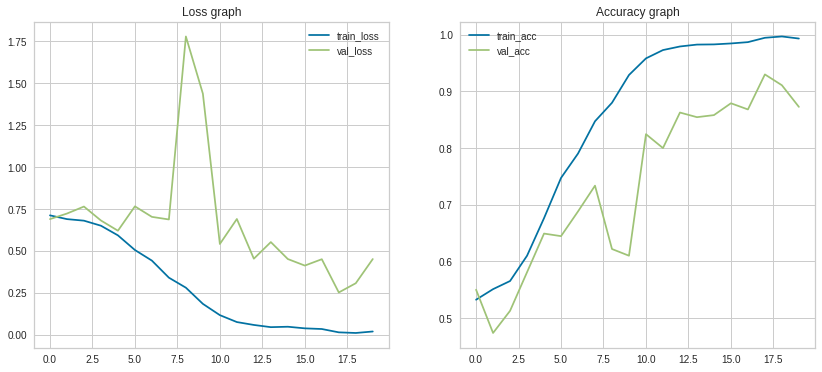

In [134]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(losses['train_loss'], label='train_loss')
plt.plot(losses['val_loss'], label='val_loss')
plt.legend()
plt.grid(True)
plt.title('Loss graph')

plt.subplot(1, 2, 2)
plt.plot(losses['train_acc'], label='train_acc')
plt.plot(losses['val_acc'], label='val_acc')
plt.legend()
plt.grid(True)
plt.title('Accuracy graph')
plt.show()

# Predict / Evaluate

In [135]:
loss, acc = evaluate(model, test_loader)
print('test_loss: {:.4f}, test_acc: {:.4f}'.format(loss, acc))

test_loss: 0.4564, test_acc: 0.8753


In [137]:
# test set 예측

tl = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset))

model.eval()
with torch.no_grad():

  for image, label in tl:

    image = image.to(DEVICE)
    pred = model(image)

f1 score:  0.8693957115009747
precision score:  0.8123861566484517
recall score:  0.9350104821802935


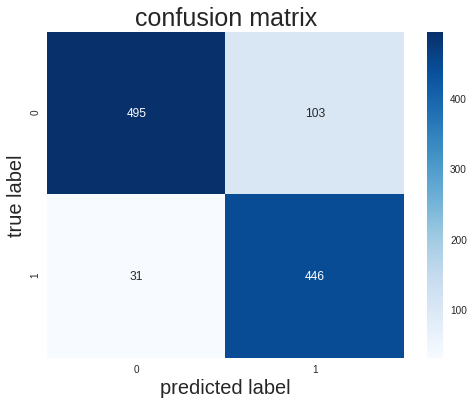

In [138]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

##confusion matrix
## metrics
## f1_score, precision, recall

# true, pred 순서
f1score = f1_score(label.cpu(), pred.cpu().round())
print('f1 score: ', f1score)


precision = precision_score(label.cpu(), pred.cpu().round())
print('precision score: ', precision)

recall = recall_score(label.cpu(), pred.cpu().round())
print('recall score: ', recall)

# true, pred 순서
cm = confusion_matrix(label.cpu(), pred.cpu().round())
tn, fp, fn, tp  = confusion_matrix(label.cpu(), pred.cpu().round()).ravel()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('confusion matrix', fontsize=25)
plt.xlabel('predicted label', fontsize=20)
plt.ylabel('true label', fontsize=20)
plt.show()

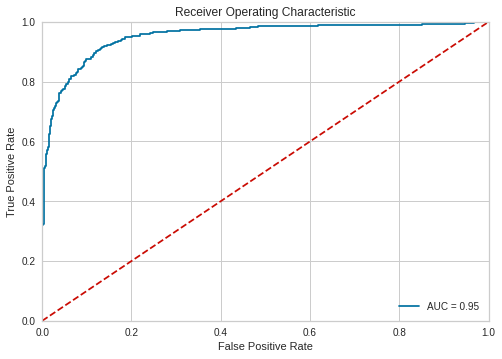

In [140]:
# ROC - AUC
#   실제 양성을 양성으로 예측하는것
# --------------------------------------
#  실제로 음성인데 양성으로 예측하는 것


import sklearn.metrics as metrics
# true, pred 순서
fpr, tpr, threshold = metrics.roc_curve(label.cpu(), pred.cpu())

roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [141]:
fn

31